# TIF345/FYM345: Project 3: A Galton board on a rocking ship

# Names 
Jonatan Haraldsson [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

Jesper Noord [noord@chalmers.se](mailto:noord@chalmers.se)

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
import sklearn
import pandas as pd
import emcee
import numpy as np
import random
import tqdm
from tqdm import trange
import keras as keras
import tensorflow as tf

# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

sns.set_palette('deep')
from matplotlib import cbook, cm
from seaborn import cm
from matplotlib.colors import LightSource
# plot in separate window
%matplotlib inline

rng = np.random.default_rng(seed = 42)

### Importing and massaging data

In [150]:
board_data = np.load('board_data.npy')

board_df = pd.DataFrame(board_data, columns = [f'bin_{i}' for i in range(32)])

display(board_df)

,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30,bin_31
0,0.0,0.0,0.0,2.0,5.0,9.0,11.0,28.0,31.0,47.0,...,8.0,8.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,...,78.0,59.0,57.0,34.0,26.0,7.0,6.0,2.0,1.0,0.0
2,0.0,0.0,0.0,1.0,4.0,8.0,19.0,18.0,27.0,47.0,...,11.0,5.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
3,1.0,8.0,13.0,57.0,79.0,85.0,116.0,109.0,119.0,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,...,88.0,54.0,70.0,28.0,25.0,14.0,8.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,76.0,75.0,54.0,36.0,26.0,11.0,2.0,3.0,0.0,0.0
9996,2.0,47.0,60.0,107.0,113.0,109.0,121.0,117.0,100.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,9.0,29.0,63.0,81.0,115.0,121.0,131.0,112.0,99.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.0,99.0,87.0,85.0,84.0,48.0,30.0,12.0,3.0,0.0


### Plots

Referring to the classical case with a Galton board, where the bead has an equal probability of bouncing to the left or the right, the distribution will converge to a binomial distribution for $N_\text{samples} \rightarrow\infty$.

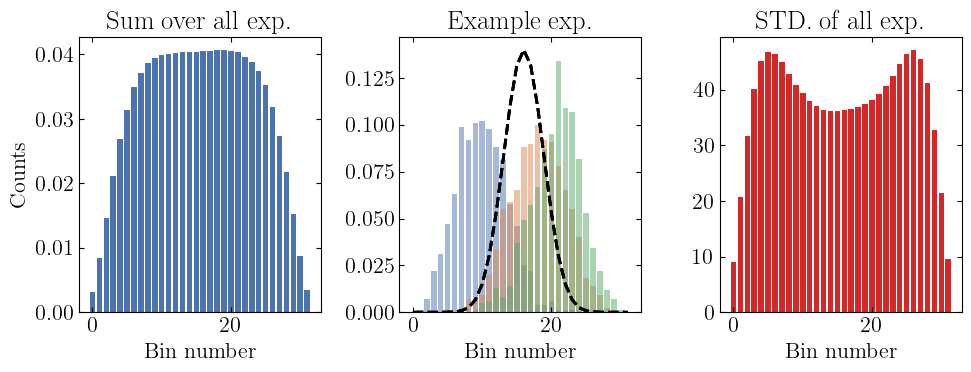

In [151]:

fig, ax = plt.subplots(1,3,figsize = (10, 4))

ax[0].bar(np.arange(32), board_data.sum(axis=0) / board_data.sum())
ax[0].set_xlabel('Bin number')
ax[0].set_ylabel('Counts')


for n in range(3):
    i = rng.integers(0, board_data.shape[0])
    ax[1].bar(np.arange(32), board_data[i]/ board_data[i].sum(),alpha=0.5)
    ax[1].plot(scipy.stats.binom.pmf(np.arange(32), n=32, p=1/2), color='black', lw=2,ls = '--')

ax[1].set_xlabel('Bin number')
ax[1].set_title('Example exp.')
ax[0].set_title('Sum over all exp.')
ax[2].set_title('STD. of all exp.')
ax[2].bar(np.arange(32), np.std(board_data,axis=0),color='tab:red')
ax[2].set_xlabel('Bin number')
plt.tight_layout()

plt.show()

## Simulate data

In [152]:
def p_peg(alpha,s,left=None):
    if left == None:
        M = 0.
    elif left:
        M = 0.5
    else:
        M = -0.5
    return 0.5 + (alpha * M + s)
    
def simulator(alpha,s, N=int(1e4)):
    rng = np.random.default_rng()
    bin_counts = np.zeros(32)
    for j in range(int(N)):
        left_bounces = 0
        left = 0
        left_ = 0
        for i in range(31):
            r = rng.uniform(0,1)
            if i == 0:
                left_ = r < p_peg(alpha,s,left=None)
                #print(f'{p_peg(alpha,s,left=None)} and r = {r} gives left = {left_}')
            else:
                left_ = r < p_peg(alpha,s,left=left)
            if left_:
                left_bounces += 1
            else:
                pass
            left = left_
        bin_counts[left_bounces] += 1
        left_bounces = 0
    return bin_counts / N 

def simulator2(alpha,s, N=int(1e3)):
    rng = np.random.default_rng()
    bin_counts = np.zeros(N)
    for j in range(int(N)):
        left_bounces = 0
        left = 0
        left_ = 0
        for i in range(31):
                r = rng.uniform(0,1)
                if i == 0:
                    left_ = r < p_peg(alpha,s,left=None)
                    #print(f'{p_peg(alpha,s,left=None)} and r = {r} gives left = {left_}')
                else:
                    left_ = r < p_peg(alpha,s,left=left)
                if left_:
                    left_bounces += 1
                else:
                    pass
                left = left_
        bin_counts[j] = 31 - left_bounces
    return bin_counts


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]
15.4776 22.81909824


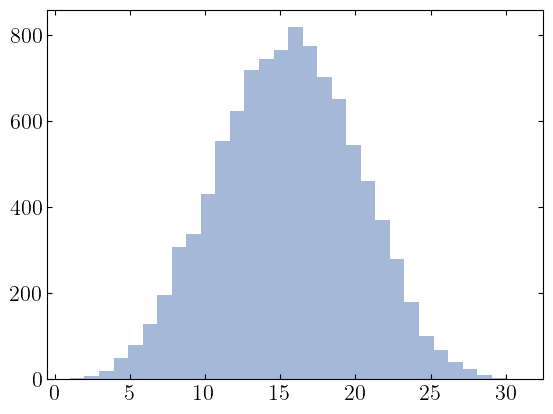

In [153]:
alpha = 0.5
s = .0

counts = simulator2(alpha,s, N=int(1e4))

print(np.unique(counts))
print(np.mean(counts), np.std(counts)**2)

plt.hist(counts, bins = len(np.unique(counts)), alpha=0.5, label='Simulated data')
plt.show()


0.10062437577446133
31
0.9129


<BarContainer object of 32 artists>

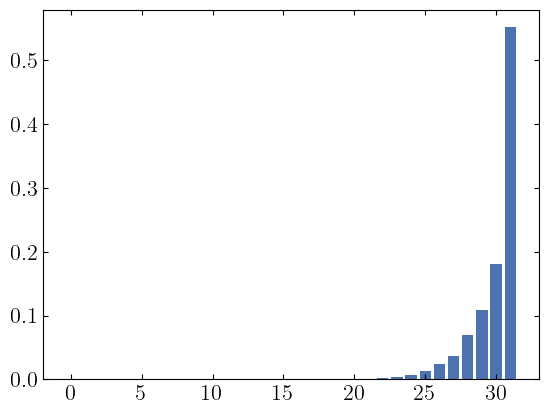

In [154]:
alpha = 0.5
s = .24
res = simulator(alpha,s)

print(res.std())
ind = np.argmax(res)
print(ind)
print(np.sum((res[ind],res[int(ind-1)],res[int(ind-1)])) / np.sum(res))

#plt.plot(scipy.stats.binom.pmf(np.arange(31), n=31, p=p_peg(alpha,s)), color='black', lw=2,ls = '--')

plt.bar(np.arange(32), res) 

## Approximate Bayesian Computation

In [155]:
def statistic(data):
    x = np.arange(len(data))
    exp_val = np.sum(data * x) 
    var = np.sum(data * (x - exp_val)**2)
    return exp_val, var
print(statistic(res))

(np.float64(29.909599999999998), np.float64(2.9134278399999998))


In [156]:
alphas = np.linspace(0,0.5,11)
ss = np.linspace(-0.25,0.25,11)
means = np.zeros((len(alphas), len(ss)))
variances = np.zeros((len(alphas), len(ss)))
for i, alpha in enumerate(alphas):
    for j, s in enumerate(ss):
        res = simulator(alpha,s)
        mean, var = statistic(res)
        means[i,j] = mean
        variances[i,j] = var

In [157]:
def grid_gen(xlim, ylim, size=50):
    x = np.linspace(xlim[0], xlim[1], size)
    y = np.linspace(ylim[0], ylim[1], size)
    X, Y = np.meshgrid(x, y)
    return X, Y


def contour_generator(xlim, ylim, size=50):
    X, Y = grid_gen(xlim, ylim, size)
    Z1 = np.zeros_like(X)
    Z2 = np.zeros_like(X)

    for i in trange(X.shape[0]):
        for j in range(X.shape[1]):
            res = simulator(X[i, j], Y[i, j])
            mean, var = statistic(res)
            Z1[i, j] = mean
            Z2[i, j] = var
    return X, Y, Z1, Z2

In [158]:
A,S,MEAN,STD = contour_generator((0,0.5),(-0.25,0.25),size=75)

 12%|█▏        | 9/75 [05:05<37:17, 33.90s/it]


KeyboardInterrupt: 

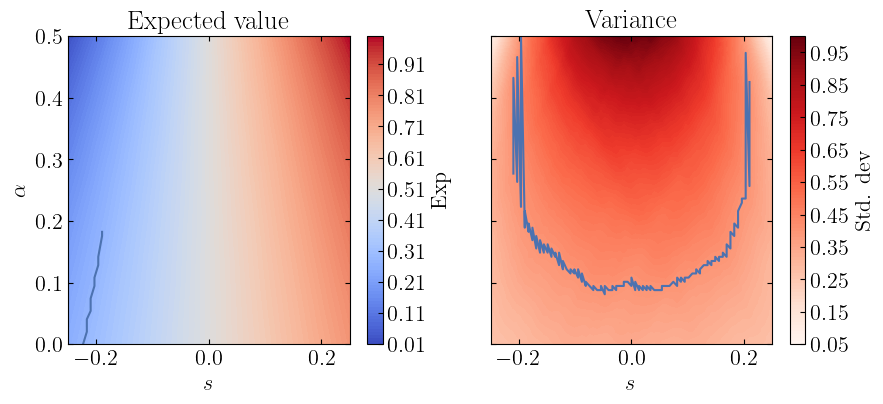

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True) 
conf0 = ax[0].contourf(S,A , MEAN/ np.max(MEAN), levels=100, cmap='coolwarm')
#ax[0].contour(A, S, Z, levels=100, c='k',alpha =0.5)
conf1 = ax[1].contourf(S, A, STD / np.max(STD) , levels=100, cmap='Reds')
ax[0].set_title('Expected value')
ax[1].set_title('Variance')
ax[0].set_ylabel(r'$\alpha$')
ax[0].set_xlabel(r'$s$')
ax[1].set_xlabel(r'$s$')

fig.colorbar(conf0, ax=ax[0],label='Exp')
fig.colorbar(conf1, ax=ax[1],label='Std. dev')#'$\\mathbb{COV}$ [eV$^2$]')

# plt.savefig('contour_plots.pdf', bbox_inches='tight')

# conts_mean = np.where(np.abs(Z - 10) < 0.2)
# conts_std = np.where(np.abs(STD/ np.max(STD) - 0.4) < 0.005)

# #A[conts], S[conts]

# ax[0].plot(S[conts_mean],A[conts_mean])
# ax[1].plot(S[conts_std],A[conts_std])


### Generate training data

In [ ]:
def generate_data(N_samples):
    train_data = np.zeros((N_samples,32))
    target_data = np.zeros((N_samples,2))
    for n in trange(N_samples):
        s = np.random.uniform(-0.25,0.25)
        a = np.random.uniform(0,0.5)
        a = 0.1
        train_data[n,:] = simulator(a,s)
        target_data[n,0] = a
        target_data[n,1] = s
    return train_data, target_data
    
# train_data, target_data = generate_data(10)
# np.save('train_data_a0.npy', train_data)
# np.save('target_data_a0.npy', target_data)

100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


In [164]:
data = np.load('train_data_a0.npy')
target = np.load('target_data_a0.npy')

In [196]:
def kernel(y_pred, y_obs):
    sq = []
    D = []
    h = 1.2
    for i in range(len(y_pred)):
        diff = (statistic(y_pred[i,:].ravel())[0] - statistic(y_obs.ravel())[0]) / h
        sq.append(diff**2)
        D.append(diff)
    SQ = np.array(sq)
    return D, np.exp(-0.5 * (SQ)) / np.sum(np.exp(-0.5 * (SQ)))

In [165]:
fraction_train = 0.70; fraction_test = 0.10; fraction_valid = 1. - fraction_train - fraction_test

data_train = data[:int(fraction_train*len(data))]
target_train = target[:int(fraction_train*len(target))]

data_test = data[int(fraction_train*len(data)):int((fraction_train+fraction_test)*len(data))+1]
target_test = target[int(fraction_train*len(data)):int((fraction_train+fraction_test)*len(target))+1]

data_valid = data[1+int((fraction_train+fraction_test)*len(data)):]
target_valid = target[1+int((fraction_train+fraction_test)*len(target)):]

print(f"Training and target data size: {len(data_train)} x {len(target_train)} ")
print(f"Testing and target data size: {len(data_test)} x {len(target_test)} ")
print(f"Validation and target data size: {len(data_valid)} x {len(target_valid)} ")

Training and target data size: 700 x 700 
Testing and target data size: 100 x 100 
Validation and target data size: 200 x 200 


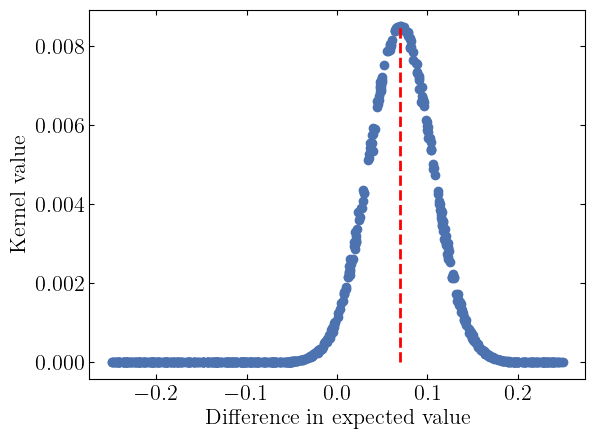

In [197]:
y_obs = data_test[-1, :]
t_obs = target_test[-1, :]

y_preds = data_train
t_preds = target_train

X = kernel(y_preds,y_obs)[0]    # Difference in summary statistics
Y = kernel(y_preds,y_obs)[1]    # Kernel size / Probability

# plt.plot(X,Y,'o')
plt.xlabel('Difference in expected value')
plt.ylabel('Kernel value')

plt.plot(target_train[:, 1], Y, 'o')
plt.vlines(t_obs[1], 0, np.max(Y), color='red', lw=2, ls='--')
